In [2]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [3]:
import matplotlib.pyplot as plt
def visualize_acc_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train','validation'],loc = 'upper left')
    plt.show()


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['train','validation'],loc = 'upper left')

In [3]:
train_dir = "E:/Sentinel 2/EuroSAT/train"
test_dir = "E:/Sentinel 2/EuroSAT/test"
image_size = 64 #Same width and height
batch_size = 50

train_datagen = ImageDataGenerator(rescale=1./255, #normalize pixel values
                                   rotation_range=30, fill_mode='nearest', #data augmentation
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   brightness_range=[0.7,1.3],
                                   validation_split = 0.1765) #15% split based on the intial dataset (0.15/0.85 = 0.17647)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   subset = 'training')
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   subset = 'validation')


Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


Raw images from the train folder for each class:
Total class = 10
Class labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']




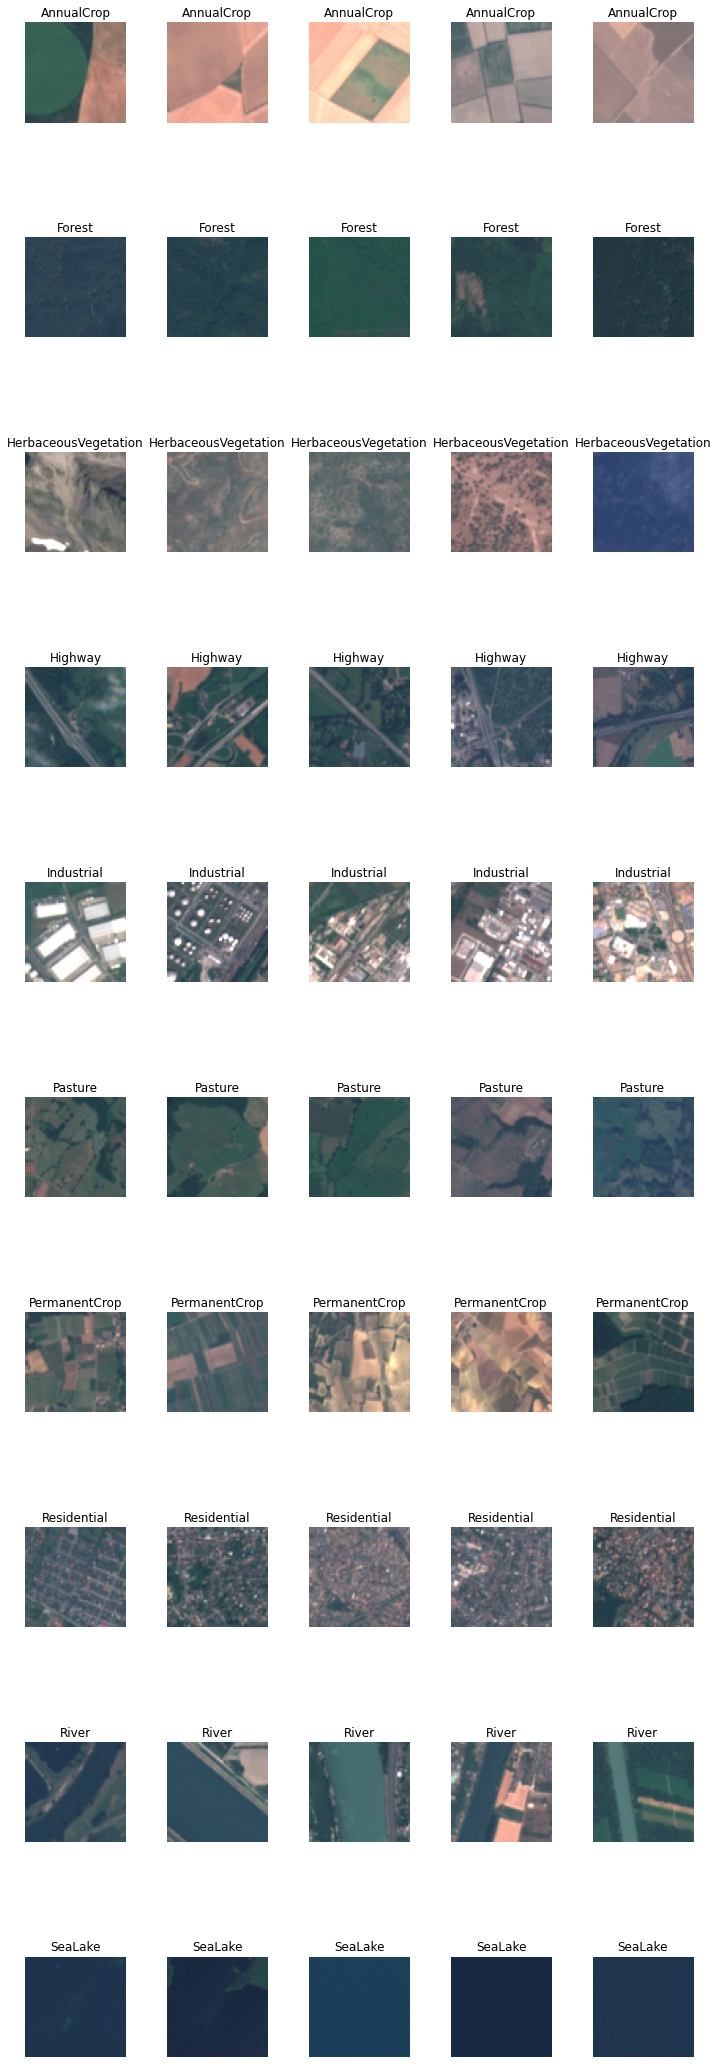

In [5]:
images=[]
num_images_per_class_dict = {}
num_plot_per_class=0

for label in train_generator.class_indices.keys():
    current_label_dir_path = os.path.join(train_dir, label)
    #print(current_label_dir_path)
    
    list_of_images = os.listdir(current_label_dir_path)
    num_plot_per_class = 5
    num_images_per_class = int(len(list_of_images))
    steps = int(num_images_per_class/num_plot_per_class)
    num_images_per_class_dict[label] = num_images_per_class
    

    for index in range(1,num_images_per_class,steps):
        path =os.path.join(current_label_dir_path ,list_of_images[index])
        img = mpimg.imread(path)
        images.append(img)

fig, axs = plt.subplots(nrows=len(train_generator.class_indices.keys()), ncols=num_plot_per_class,figsize=(10,30))
fig.tight_layout()

class_image_count = 0
class_list = list(train_generator.class_indices.keys())

print("Raw images from the train folder for each class:")
print("Total class = {0}".format(len(train_generator.class_indices.keys())))
print("Class labels = {0}\n\n".format(class_list))

for row in range(len(train_generator.class_indices.keys())):
    for col in range(num_plot_per_class):
        plt.axis('off')
        axs[row,col].imshow(images[class_image_count])
        axs[row,col].axis('off')
        axs[row,col].set_title(class_list[row])
        class_image_count+=1


Some images altered by data augmentation:




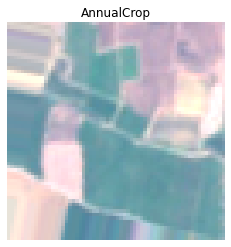

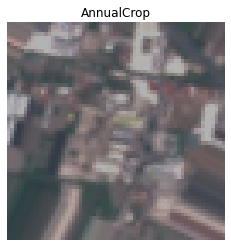

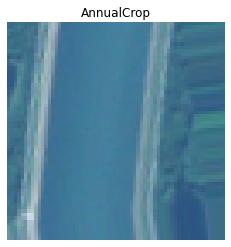

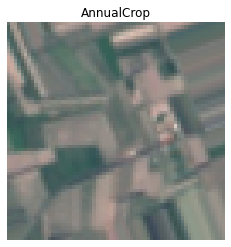

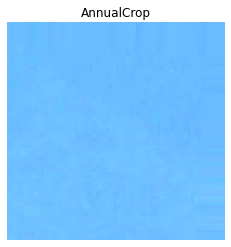

In [6]:
print("Some images altered by data augmentation:\n\n")
plt.figure()
x,y = train_generator.next()
for i in range(0,5):
    image = x[i]
    plt.imshow(image)
    plt.title(os.path.dirname(train_generator.filenames[i]))
    plt.axis('off')
    plt.show() 

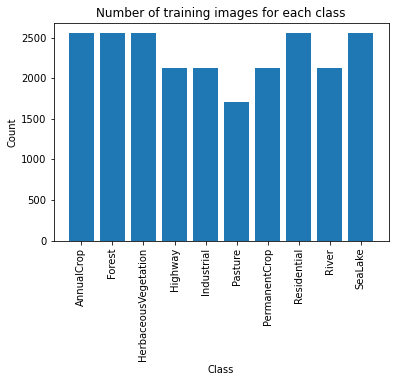

In [7]:
plt.bar(range(len(num_images_per_class_dict)), list(num_images_per_class_dict.values()), align='center')
plt.title("Number of training images for each class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(len(num_images_per_class_dict)), list(num_images_per_class_dict.keys()))
plt.xticks(rotation=90)
plt.show()

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size = (image_size,image_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle = True,
                                                 )


Found 4050 images belonging to 10 classes.


# Approach 1 - Transfer Learning with VGG16 model

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras import optimizers


class_num = len(train_generator.class_indices)


vgg16_conv = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (image_size,image_size,3))

for layer in vgg16_conv.layers[:-4]: #Only make the last 5 layers trainable with new data
    layer.trainable = False

model = Sequential()
model.add(vgg16_conv)
model.add(Flatten())
model.add(Dense(class_num,activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizers.Adam(lr=1e-4),
             metrics = ['acc'])
print(model.summary())



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                20490     
Total params: 14,735,178
Trainable params: 7,099,914
Non-trainable params: 7,635,264
_________________________________________________________________
None


In [25]:
history  = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ train_generator.batch_size,
                              epochs = 120,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples/ validation_generator.batch_size,
                              verbose = 1)


Epoch 1/120
391/390 [==============================] - 123s 314ms/step - loss: 1.5097 - acc: 0.4629 - val_loss: 0.4600 - val_acc: 0.6558
Epoch 2/120
391/390 [==============================] - 32s 82ms/step - loss: 0.8156 - acc: 0.7106 - val_loss: 0.4446 - val_acc: 0.7678
Epoch 3/120
391/390 [==============================] - 31s 80ms/step - loss: 0.5960 - acc: 0.7883 - val_loss: 0.3078 - val_acc: 0.8022
Epoch 4/120
391/390 [==============================] - 31s 80ms/step - loss: 0.5433 - acc: 0.8077 - val_loss: 0.1960 - val_acc: 0.8455
Epoch 5/120
391/390 [==============================] - 32s 82ms/step - loss: 0.4855 - acc: 0.8309 - val_loss: 0.2175 - val_acc: 0.8659
Epoch 6/120
391/390 [==============================] - 33s 84ms/step - loss: 0.4388 - acc: 0.8473 - val_loss: 0.4462 - val_acc: 0.8138
Epoch 7/120
391/390 [==============================] - 33s 83ms/step - loss: 0.4224 - acc: 0.8514 - val_loss: 0.2279 - val_acc: 0.8667
Epoch 8/120
391/390 [==============================]

In [40]:
visualize_acc_loss(history)    

First Attempt:

1. high degree of fluctuation validation accuracy (possible cause:mini-batch implementation that has not converge)


Second Attempt:
- Decrease learning rate from 5e-4 to 1e-4
- increase epoch to 50
- increase batch size from 30 to 50
- set last 4 layers of vgg16 to be trainable instead of all untrainable   
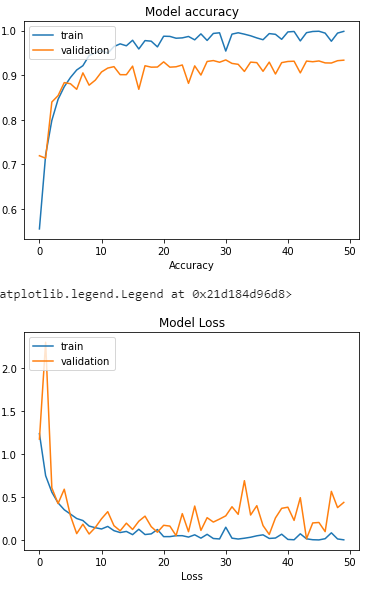    
 
1. Validation accuracy fluctuate but better than first attempt
 
Third Attempt: 
  - introduce image augmentation
  - increase epoch from 50 to 100
  
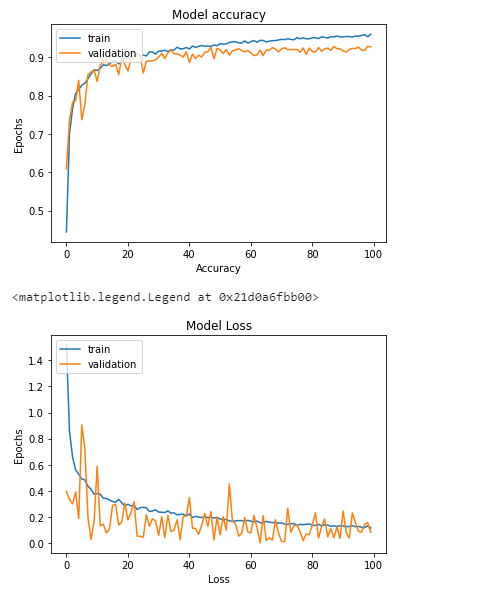


Fourth Attempt: 
  - Added visualization code for images before and after data augmentation
  - tune brightness range of data augmentation from +-0.5 to +-0.3 (Due to some images being overly bright after augmentation)
  - Increase epoch number from 100 to 120 based on the training and validation loss pattern.
  
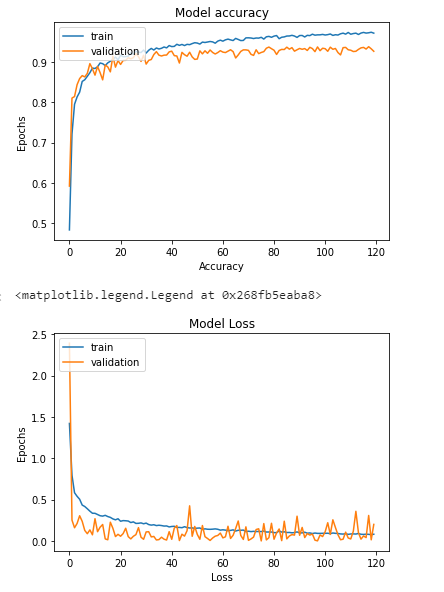


Confusion Matrix


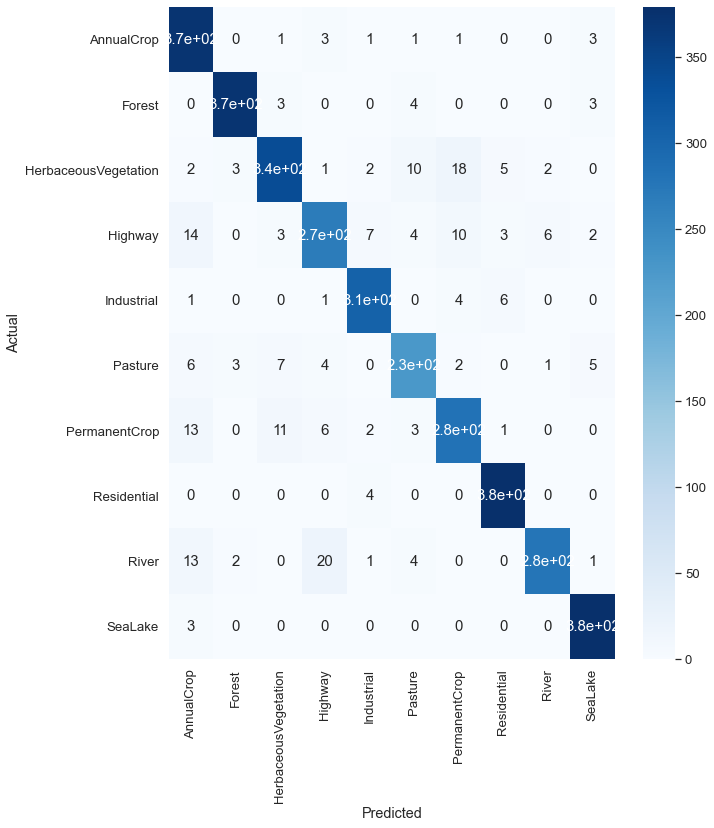

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.88      0.97      0.92       382
              Forest       0.98      0.97      0.98       382
HerbaceousVegetation       0.93      0.89      0.91       382
             Highway       0.88      0.85      0.86       318
          Industrial       0.95      0.96      0.95       318
             Pasture       0.90      0.89      0.89       255
       PermanentCrop       0.89      0.89      0.89       318
         Residential       0.96      0.99      0.98       382
               River       0.97      0.87      0.92       318
             SeaLake       0.96      0.99      0.98       382

            accuracy                           0.93      3437
           macro avg       0.93      0.93      0.93      3437
        weighted avg       0.93      0.93      0.93      3437



In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

Y_pred = model.predict_generator(validation_generator, 3437 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf_mat = confusion_matrix(validation_generator.classes, y_pred)

df_cm = pd.DataFrame(conf_mat, columns=class_list, index = class_list)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,12))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 15})
plt.show()


print('Classification Report')
target_names = class_list
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Based on the confusion matrix, it seems like the model struggles to distinguish:
1. River -> Highway (Both class share somewhat similar appearance in some images where a highway line can easily be mistaken as river)
2. HerbaceousVegetation -> PermanentCrop  (Both classes have blocky pattern patch of lands)
3. Highway -> AnnualCrop (Highway images are surrounded by greens and annualcrop's blocky nature with lines can be mistaken for highway)

In [28]:
scores = model.evaluate_generator(test_generator,4050) #4050 test images 
print("Test Accuracy = ", scores[1])

Test Accuracy =  0.907654345035553


In [29]:
import pickle
filename = "sentinel2_transf_vgg16_model.sav"
pickle.dump(model, open(filename, 'wb'))

In [30]:
loaded_model = pickle.load(open(filename, 'rb'))
scores = loaded_model.evaluate_generator(test_generator,4050) 
print("Test Accuracy = ", scores[1])

Test Accuracy =  0.907654345035553


# Approach 2 - Multi-layer perceptron

In [4]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [40]:
#Initial training saw bad training and validation performance (Approx 10% training and 20% acc valid). The issue was the dataset was not shuffled. 
#After shuffling performance there is a significant increase to approx 50% for valid and 60% for training

train_dir = "E:/Sentinel 2/EuroSAT/train"
test_dir = "E:/Sentinel 2/EuroSAT/test"
image_size = 64 #Same width and height
batch_size = 512

train_datagen = ImageDataGenerator(rescale=1./255, #normalize pixel values
                                   rotation_range=30, fill_mode='nearest', #data augmentation
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   brightness_range=[0.7,1.3],
                                   validation_split = 0.1765) #15% split based on the intial dataset (0.15/0.85 = 0.17647)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   subset = 'training')
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   subset = 'validation')
 

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size = (image_size,image_size),
                                                 batch_size = 50,
                                                 class_mode = 'categorical',
                                                 shuffle = True,
                                                 )

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input, LeakyReLU
from keras import initializers
from keras import optimizers


leaky_relu_alpha = 0.1
class_num = len(train_generator.class_indices)

model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=(64,64,3)))
model_mlp.add(Dense(256,kernel_initializer='he_uniform'))
model_mlp.add(LeakyReLU(alpha=leaky_relu_alpha))

model_mlp.add(Dense(256,kernel_initializer='he_uniform'))
model_mlp.add(LeakyReLU(alpha=leaky_relu_alpha))

model_mlp.add(Dense(256,kernel_initializer='he_uniform'))
model_mlp.add(LeakyReLU(alpha=leaky_relu_alpha))

model_mlp.add(Dense(class_num))
model_mlp.add(Activation('softmax'))


model_mlp.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_mlp.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3145984   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)              

In [ ]:
history_mlp  = model_mlp.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ train_generator.batch_size,
                              epochs = 150,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples/ validation_generator.batch_size,
                              verbose = 1)

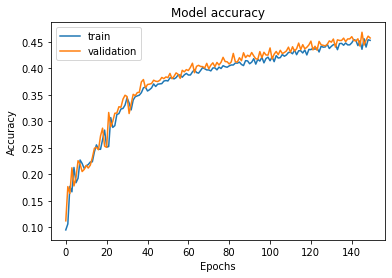

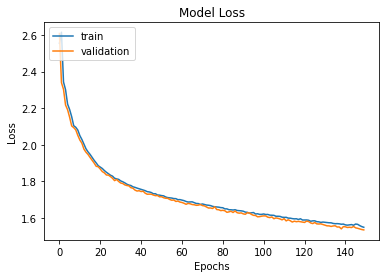

In [23]:
visualize_acc_loss(history_mlp)

In [ ]:
history_mlp = model_mlp.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ train_generator.batch_size,
                              epochs = 150,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples/ validation_generator.batch_size,
                              verbose = 1)
#total 300 epochs including the previous 150

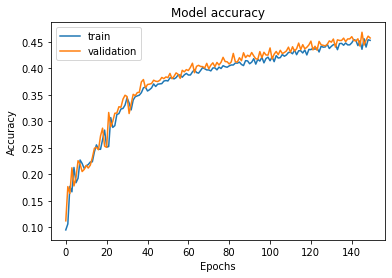

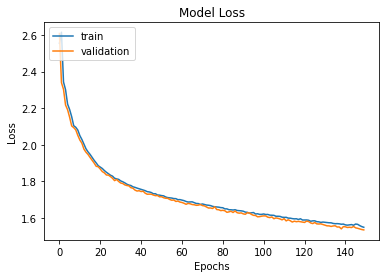

In [27]:
visualize_acc_loss(history_mlp)

In [22]:
from keras.layers.normalization import BatchNormalization

leaky_relu_alpha = 0.1
class_num = len(train_generator.class_indices)

model_mlp_2 = Sequential()
model_mlp_2.add(Flatten(input_shape=(64,64,3)))
model_mlp_2.add(Dense(256,kernel_initializer='he_uniform'))
model_mlp_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_mlp_2.add(BatchNormalization())
model_mlp_2.add(Dropout(0.5))


model_mlp_2.add(Dense(256,kernel_initializer='he_uniform'))
model_mlp_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_mlp_2.add(BatchNormalization())
model_mlp_2.add(Dropout(0.5))

model_mlp_2.add(Dense(256,kernel_initializer='he_uniform'))
model_mlp_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_mlp_2.add(BatchNormalization())
model_mlp_2.add(Dropout(0.5))

model_mlp_2.add(Dense(256,kernel_initializer='he_uniform'))
model_mlp_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_mlp_2.add(BatchNormalization())
model_mlp_2.add(Dropout(0.5))


model_mlp_2.add(Dense(class_num))
model_mlp_2.add(Activation('softmax'))


model_mlp_2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=5e-4),metrics=['accuracy'])

print(model_mlp_2.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               3145984   
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 256)              

In [23]:
history_mlp_2  = model_mlp_2.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ train_generator.batch_size,
                              epochs = 200,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples/ validation_generator.batch_size,
                              verbose = 1)

Epoch 1/200
37/36 [==============================] - 30s 818ms/step - loss: 2.9243 - accuracy: 0.1928 - val_loss: 7.0235 - val_accuracy: 0.1827
Epoch 2/200
37/36 [==============================] - 30s 820ms/step - loss: 2.4487 - accuracy: 0.2441 - val_loss: 3.0215 - val_accuracy: 0.2160
Epoch 3/200
37/36 [==============================] - 32s 866ms/step - loss: 2.2551 - accuracy: 0.2593 - val_loss: 2.7260 - val_accuracy: 0.2277
Epoch 4/200
37/36 [==============================] - 29s 785ms/step - loss: 2.1153 - accuracy: 0.2751 - val_loss: 2.3543 - val_accuracy: 0.2595
Epoch 5/200
37/36 [==============================] - 29s 785ms/step - loss: 2.0044 - accuracy: 0.2907 - val_loss: 1.7685 - val_accuracy: 0.3170
Epoch 6/200
37/36 [==============================] - 29s 789ms/step - loss: 1.9194 - accuracy: 0.3101 - val_loss: 1.7180 - val_accuracy: 0.3672
Epoch 7/200
37/36 [==============================] - 29s 783ms/step - loss: 1.8557 - accuracy: 0.3190 - val_loss: 1.5843 - val_accuracy:

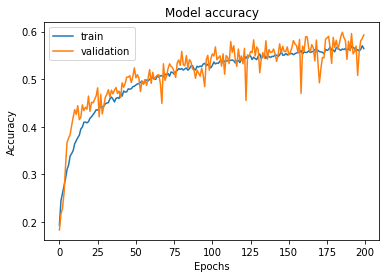

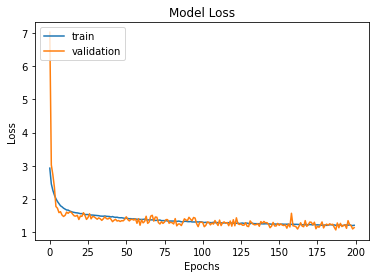

In [24]:
visualize_acc_loss(history_mlp_2)

In [25]:
#Additional 50 epochs
history_mlp_3  = model_mlp_2.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ train_generator.batch_size,
                              epochs = 50,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples/ validation_generator.batch_size,
                              verbose = 1)

Epoch 1/50
37/36 [==============================] - 169s 5s/step - loss: 1.1983 - accuracy: 0.5718 - val_loss: 1.1275 - val_accuracy: 0.5916
Epoch 2/50
37/36 [==============================] - 33s 882ms/step - loss: 1.2020 - accuracy: 0.5639 - val_loss: 1.2175 - val_accuracy: 0.5704
Epoch 3/50
37/36 [==============================] - 33s 882ms/step - loss: 1.1883 - accuracy: 0.5694 - val_loss: 1.2387 - val_accuracy: 0.5496
Epoch 4/50
37/36 [==============================] - 33s 889ms/step - loss: 1.1932 - accuracy: 0.5669 - val_loss: 1.2314 - val_accuracy: 0.5817
Epoch 5/50
37/36 [==============================] - 33s 881ms/step - loss: 1.1972 - accuracy: 0.5660 - val_loss: 1.1700 - val_accuracy: 0.5857
Epoch 6/50
37/36 [==============================] - 33s 886ms/step - loss: 1.1886 - accuracy: 0.5685 - val_loss: 1.0678 - val_accuracy: 0.5921
Epoch 7/50
37/36 [==============================] - 32s 876ms/step - loss: 1.1959 - accuracy: 0.5666 - val_loss: 1.0708 - val_accuracy: 0.5936
E

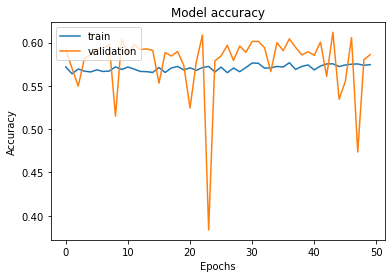

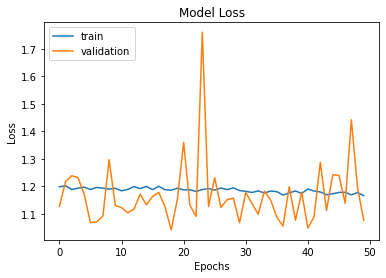

In [26]:
visualize_acc_loss(history_mlp_3)
#model's improvement graident is closely to flat-lining, more epochs will result in minimal improvement but consume a lot of time.

Confusion Matrix


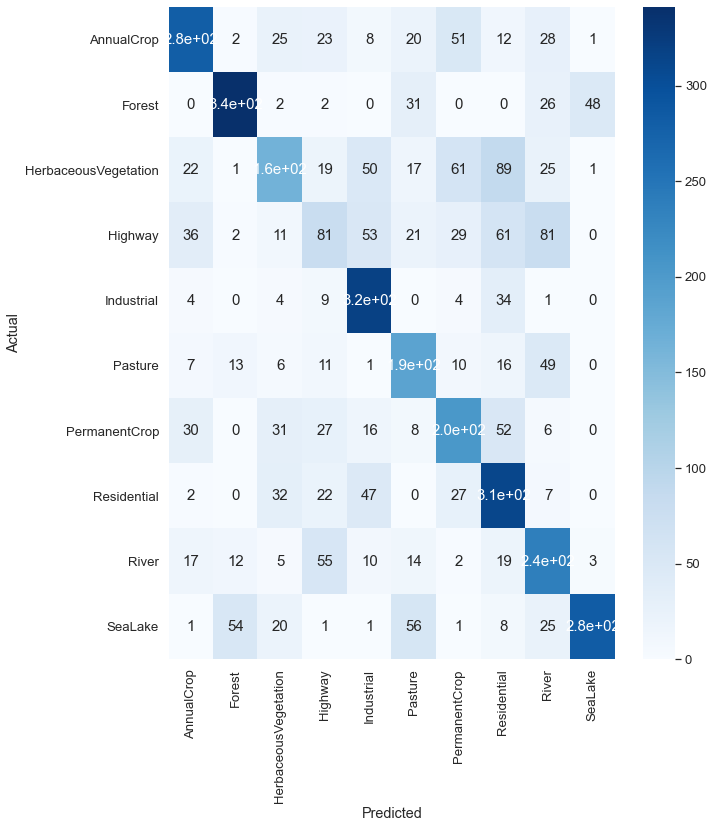

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.70      0.62      0.66       450
              Forest       0.80      0.76      0.78       450
HerbaceousVegetation       0.55      0.37      0.44       450
             Highway       0.32      0.22      0.26       375
          Industrial       0.63      0.85      0.72       375
             Pasture       0.53      0.62      0.57       300
       PermanentCrop       0.53      0.55      0.54       375
         Residential       0.52      0.70      0.59       450
               River       0.49      0.63      0.55       375
             SeaLake       0.84      0.63      0.72       450

            accuracy                           0.60      4050
           macro avg       0.59      0.59      0.58      4050
        weighted avg       0.60      0.60      0.59      4050



In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

class_list = list(train_generator.class_indices.keys())
Y_pred = model_mlp_2.predict_generator(validation_generator, 4050 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf_mat = confusion_matrix(validation_generator.classes, y_pred)

df_cm = pd.DataFrame(conf_mat, columns=class_list, index = class_list)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,12))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 15})
plt.show()


print('Classification Report')
target_names = class_list
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [43]:
scores = model_mlp_2.evaluate_generator(test_generator,4050) #4050 test images 
print("Test Accuracy = ", scores[1])
# Improvement that can be considered would be increasing the neurons per hidden layer and add more hidden layer to enable model to capture more 
# complex features to make it easier for it to distinguish between classes. Weight decay should also be introduced to reduce convergence time.


Test Accuracy =  0.522469162940979


In [46]:
# Compared to vgg16 network which are deeper and uses conv layer instead of FC, the MLP model still have much room for improvement.(Will revisit if there is spare time)
# Will proceed with third approach(custom CNN) which will use convolutional layers and FC layers which theoretically works better with images.
print(vgg16_conv.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

# Approach 3 - Convolutional Neural Network(CNN)

In [57]:
import math 
train_dir = "E:/Sentinel 2/EuroSAT/train"
test_dir = "E:/Sentinel 2/EuroSAT/test"
image_size = 64 #Same width and height
batch_size = 512

train_datagen = ImageDataGenerator(rescale=1./255, #normalize pixel values
                                   rotation_range=30, fill_mode='nearest', #data augmentation
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   brightness_range=[0.7,1.3],
                                   validation_split = 0.1765) #15% split based on the intial dataset (0.15/0.85 = 0.17647)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   seed=1,
                                                   subset = 'training')
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   seed=1,
                                                   shuffle = True,
                                                   subset = 'validation')
 

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size = (image_size,image_size),
                                                 batch_size = 50,
                                                 class_mode = 'categorical',
                                                 shuffle = False  
                                                 )

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, LeakyReLU,MaxPooling2D,Conv2D,BatchNormalization
from keras import initializers
from keras import optimizers

#base model with 3 conv layers
class_num = len(train_generator.class_indices)

model_cnn = Sequential()
model_cnn.add(Conv2D(32,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
model_cnn.add(MaxPooling2D())

model_cnn.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model_cnn.add(MaxPooling2D())

model_cnn.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model_cnn.add(MaxPooling2D())


model_cnn.add(Flatten())

model_cnn.add(Dense(256))
model_cnn.add(Dense(class_num))
model_cnn.add(Activation('softmax'))


model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_cnn.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)            

Epoch 1/25
 - 32s - loss: 2.0458 - accuracy: 0.2320 - val_loss: 1.7741 - val_accuracy: 0.3489
Epoch 2/25
 - 33s - loss: 1.6954 - accuracy: 0.4003 - val_loss: 1.5893 - val_accuracy: 0.4568
Epoch 3/25
 - 31s - loss: 1.4986 - accuracy: 0.4776 - val_loss: 1.4245 - val_accuracy: 0.5244
Epoch 4/25
 - 30s - loss: 1.3437 - accuracy: 0.5363 - val_loss: 1.1926 - val_accuracy: 0.5479
Epoch 5/25
 - 31s - loss: 1.2414 - accuracy: 0.5625 - val_loss: 1.2020 - val_accuracy: 0.5877
Epoch 6/25
 - 30s - loss: 1.1771 - accuracy: 0.5825 - val_loss: 1.1391 - val_accuracy: 0.5995
Epoch 7/25
 - 32s - loss: 1.1272 - accuracy: 0.5981 - val_loss: 1.1446 - val_accuracy: 0.6111
Epoch 8/25
 - 29s - loss: 1.0876 - accuracy: 0.6166 - val_loss: 1.0304 - val_accuracy: 0.6232
Epoch 9/25
 - 28s - loss: 1.0770 - accuracy: 0.6211 - val_loss: 1.0290 - val_accuracy: 0.6348
Epoch 10/25
 - 30s - loss: 1.0309 - accuracy: 0.6372 - val_loss: 1.0409 - val_accuracy: 0.6405
Epoch 11/25
 - 29s - loss: 1.0072 - accuracy: 0.6467 - val_

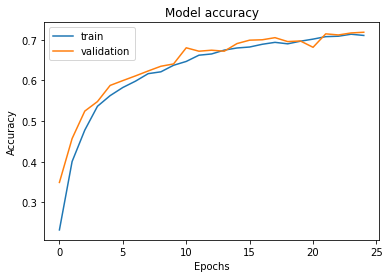

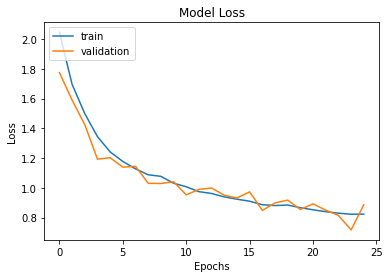

In [12]:
history_cnn  = model_cnn.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ train_generator.batch_size,
                              epochs = 25,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples/validation_generator.batch_size,
                              verbose = 2)
visualize_acc_loss(history_cnn)

In [13]:
#Improved base model(BatchNorm before activation + leaky relu)
leaky_relu_alpha = 0.1

model_cnn_2 = Sequential()
model_cnn_2.add(Conv2D(32,(3,3),input_shape=(64,64,3),padding='same',kernel_initializer= 'he_uniform'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2.add(MaxPooling2D())

model_cnn_2.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2.add(MaxPooling2D())


model_cnn_2.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2.add(MaxPooling2D())


model_cnn_2.add(Flatten())

model_cnn_2.add(Dense(256))
model_cnn_2.add(Dense(class_num))
model_cnn_2.add(Activation('softmax'))


model_cnn_2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_cnn_2.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)       

Epoch 1/25
 - 29s - loss: 1.7492 - accuracy: 0.3981 - val_loss: 2.3326 - val_accuracy: 0.1854
Epoch 2/25
 - 30s - loss: 1.2173 - accuracy: 0.5643 - val_loss: 2.5421 - val_accuracy: 0.1657
Epoch 3/25
 - 29s - loss: 1.0862 - accuracy: 0.6113 - val_loss: 3.1457 - val_accuracy: 0.1257
Epoch 4/25
 - 29s - loss: 0.9998 - accuracy: 0.6507 - val_loss: 3.2691 - val_accuracy: 0.1230
Epoch 5/25
 - 28s - loss: 0.9366 - accuracy: 0.6702 - val_loss: 3.4744 - val_accuracy: 0.1437
Epoch 6/25
 - 28s - loss: 0.9034 - accuracy: 0.6823 - val_loss: 3.4949 - val_accuracy: 0.1709
Epoch 7/25
 - 29s - loss: 0.8568 - accuracy: 0.6984 - val_loss: 3.4219 - val_accuracy: 0.1812
Epoch 8/25
 - 29s - loss: 0.8390 - accuracy: 0.7034 - val_loss: 3.2285 - val_accuracy: 0.2284
Epoch 9/25
 - 29s - loss: 0.7993 - accuracy: 0.7197 - val_loss: 2.3374 - val_accuracy: 0.3126
Epoch 10/25
 - 29s - loss: 0.7890 - accuracy: 0.7180 - val_loss: 1.8940 - val_accuracy: 0.4010
Epoch 11/25
 - 28s - loss: 0.7842 - accuracy: 0.7234 - val_

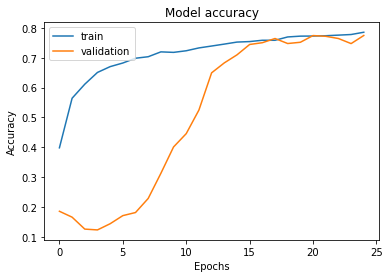

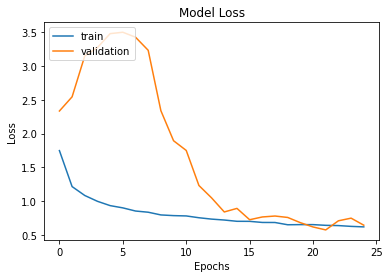

In [14]:
history_cnn_2  = model_cnn_2.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ train_generator.batch_size,
                              epochs = 25,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples/ validation_generator.batch_size,
                              verbose = 2)
visualize_acc_loss(history_cnn_2)

# Why validation loss increase then decrease?
__debunked__ are potential factors that were explored in separate notebook and has produced unfavourable result
1. Validation loss pattern might be caused by the validation and train steps in the fit generator. Initial approach (__debunked__)
    - history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples// train_generator.batch_size,
                              epochs = 50,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples// validation_generator.batch_size,
                              verbose = 2)
            
- The batch size was set to 512 and remaining data that does not fit the batch size (approx 500 from and training(2.6%) and validation(12.35%)) were discarded. Solution:
    - history = model.fit_generator(train_generator,
                              steps_per_epoch = math.ceil(train_generator.samples/ train_generator.batch_size),
                              epochs = 50,
                              validation_data = validation_generator,
                              validation_steps = math.ceil(validation_generator.samples/ validation_generator.batch_size),
                              verbose = 2)
                              
- Base model which uses the initial approach were changed despite the absence of abnormal pattern of validation loss. Result are as follow.

2. This behaviour could be expected if One Cycle Policy is utilize to configure the learning rate but that is not the case here 
    - https://forums.fast.ai/t/training-validation-loss-increases-then-decreases/46022/6
    
    
3. Maybe data augmentation of training data and validation data cause both to slightly deviate from initial data distribution which cause the network to initially face difficulty in classifying the validation data (__debunked__)

4. Something to do with BatchNormalization as the base cnn model without BatchNormalization does not exhibit such behaviour. (__The factor causing this validation pattern__)
    - Refer to the cell directly below
    - model_cnn_2 WITHOUT batch normalization
    - Aside from initial abnormal pattern, batch normalization allows the network to converge faster as intended
5. __Final part__ (Mistakes made with imagedatagenerator) of the notebook discovered that if validation data generator's __shuffling = False__, the network will exhibit __normal behaviour__ with batch normalization


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 16, 16, 64)      

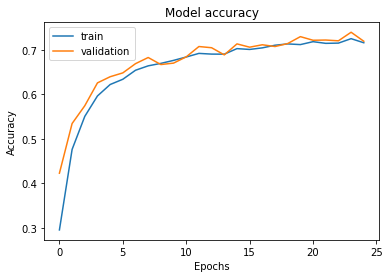

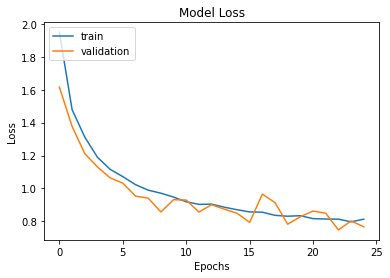

In [62]:
#To diagnose what is causing the increase in validation loss in the first few epochs

leaky_relu_alpha = 0.1

model_cnn_check_valid = Sequential()
model_cnn_check_valid.add(Conv2D(32,(3,3),input_shape=(64,64,3),padding='same',kernel_initializer= 'he_uniform'))
model_cnn_check_valid.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_check_valid.add(MaxPooling2D())

model_cnn_check_valid.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_check_valid.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_check_valid.add(MaxPooling2D())


model_cnn_check_valid.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_check_valid.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_check_valid.add(MaxPooling2D())


model_cnn_check_valid.add(Flatten())

model_cnn_check_valid.add(Dense(256))
model_cnn_check_valid.add(Dense(class_num))
model_cnn_check_valid.add(Activation('softmax'))


model_cnn_check_valid.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_cnn_check_valid.summary())

history_cnn_check_valid  = model_cnn_check_valid.fit_generator(train_generator,
                              steps_per_epoch = math.ceil(train_generator.samples/ train_generator.batch_size),
                              epochs = 25,
                              validation_data = validation_generator,
                              validation_steps = math.ceil(validation_generator.samples/ validation_generator.batch_size),
                              verbose = 2)
visualize_acc_loss(history_cnn_check_valid)

## Models trained with modified steps

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 4096)            

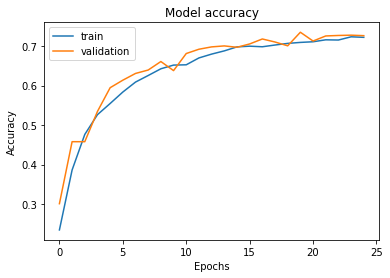

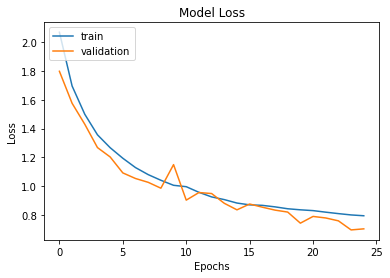

In [58]:
#modified steps base model with 3 conv layers
class_num = len(train_generator.class_indices)

model_cnn = Sequential()
model_cnn.add(Conv2D(32,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
model_cnn.add(MaxPooling2D())

model_cnn.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model_cnn.add(MaxPooling2D())

model_cnn.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model_cnn.add(MaxPooling2D())


model_cnn.add(Flatten())

model_cnn.add(Dense(256))
model_cnn.add(Dense(class_num))
model_cnn.add(Activation('softmax'))


model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_cnn.summary())

history_cnn  = model_cnn.fit_generator(train_generator,
                              steps_per_epoch = math.ceil(train_generator.samples/ train_generator.batch_size),
                              epochs = 25,
                              validation_data = validation_generator,
                              validation_steps = math.ceil(validation_generator.samples/validation_generator.batch_size),
                              verbose = 2)
visualize_acc_loss(history_cnn)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_39 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_40 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 32, 32, 64)      

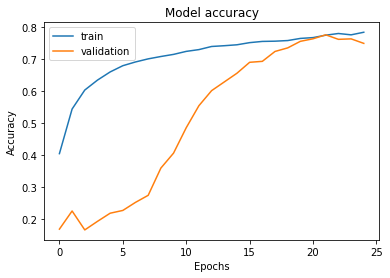

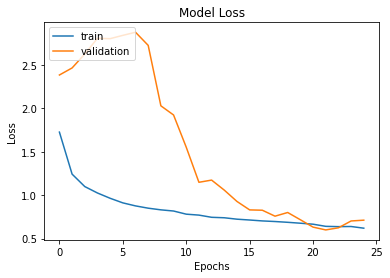

In [55]:
#modified steps Improved base model(BatchNorm before activation + leaky relu)
leaky_relu_alpha = 0.1

model_cnn_2 = Sequential()
model_cnn_2.add(Conv2D(32,(3,3),input_shape=(64,64,3),padding='same',kernel_initializer= 'he_uniform'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2.add(MaxPooling2D())

model_cnn_2.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2.add(MaxPooling2D())


model_cnn_2.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2.add(MaxPooling2D())


model_cnn_2.add(Flatten())

model_cnn_2.add(Dense(256))
model_cnn_2.add(Dense(class_num))
model_cnn_2.add(Activation('softmax'))


model_cnn_2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_cnn_2.summary())

history_cnn_2  = model_cnn_2.fit_generator(train_generator,
                              steps_per_epoch = math.ceil(train_generator.samples/ train_generator.batch_size),
                              epochs = 25,
                              validation_data = validation_generator,
                              validation_steps = math.ceil(validation_generator.samples/ validation_generator.batch_size),
                              verbose = 2)
visualize_acc_loss(history_cnn_2)

In [30]:
#Improved base model(BatchNorm after activation + leaky relu)
leaky_relu_alpha = 0.1

model_cnn_2_5 = Sequential()
model_cnn_2_5.add(Conv2D(32,(3,3),input_shape=(64,64,3),padding='same',kernel_initializer= 'he_uniform'))
model_cnn_2_5.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2_5.add(BatchNormalization())
model_cnn_2_5.add(MaxPooling2D())

model_cnn_2_5.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2_5.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2_5.add(BatchNormalization())
model_cnn_2_5.add(MaxPooling2D())


model_cnn_2_5.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2_5.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2_5.add(BatchNormalization())
model_cnn_2_5.add(MaxPooling2D())


model_cnn_2_5.add(Flatten())

model_cnn_2_5.add(Dense(256))
model_cnn_2_5.add(Dense(class_num))
model_cnn_2_5.add(Activation('softmax'))


model_cnn_2_5.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_cnn_2_5.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 64)      

Epoch 1/25
 - 29s - loss: 1.6833 - accuracy: 0.4629 - val_loss: 2.4429 - val_accuracy: 0.1590
Epoch 2/25
 - 29s - loss: 1.1170 - accuracy: 0.6142 - val_loss: 2.3586 - val_accuracy: 0.1625
Epoch 3/25
 - 29s - loss: 0.9752 - accuracy: 0.6575 - val_loss: 2.7761 - val_accuracy: 0.1464
Epoch 4/25
 - 29s - loss: 0.9004 - accuracy: 0.6887 - val_loss: 3.1964 - val_accuracy: 0.1560
Epoch 5/25
 - 29s - loss: 0.8561 - accuracy: 0.7044 - val_loss: 3.7382 - val_accuracy: 0.1773
Epoch 6/25
 - 31s - loss: 0.8215 - accuracy: 0.7141 - val_loss: 4.4533 - val_accuracy: 0.1840
Epoch 7/25
 - 28s - loss: 0.7875 - accuracy: 0.7225 - val_loss: 4.7010 - val_accuracy: 0.2165
Epoch 8/25
 - 28s - loss: 0.7631 - accuracy: 0.7311 - val_loss: 5.3580 - val_accuracy: 0.2365
Epoch 9/25
 - 28s - loss: 0.7316 - accuracy: 0.7426 - val_loss: 6.4261 - val_accuracy: 0.2585
Epoch 10/25
 - 28s - loss: 0.7323 - accuracy: 0.7476 - val_loss: 6.5091 - val_accuracy: 0.2815
Epoch 11/25
 - 28s - loss: 0.7037 - accuracy: 0.7529 - val_

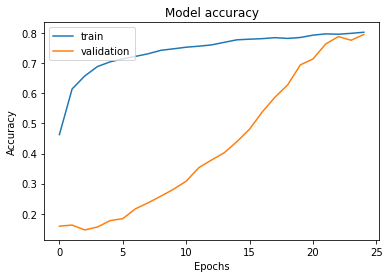

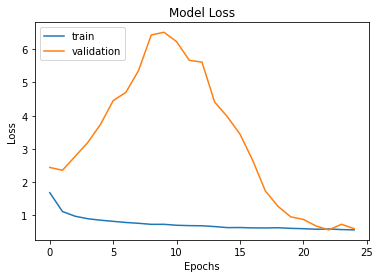

In [31]:
history_cnn_2_5  = model_cnn_2_5.fit_generator(train_generator,
                              steps_per_epoch =  math.ceil(train_generator.samples/train_generator.batch_size),
                              epochs = 25,
                              validation_data = validation_generator,
                              validation_steps =  math.ceil(validation_generator.samples/validation_generator.batch_size),
                              verbose = 2)
visualize_acc_loss(history_cnn_2_5)

From the two configuration
1. batchnorm -> activation
2. activation -> batchnorm 

It seems like the second configuration model yields better result in a shorter duration. Original paper suggested putting Batch norm before activation but there has been cases where second approach are more favorable in terms of convergence speed and model's performance.
https://arxiv.org/pdf/1502.03167.pdf

In [59]:
import pickle

scores_1 = model_cnn.evaluate_generator(test_generator,4050) #4050 test images 
print("Validation Accuracy = 72.47%")
print("Test Accuracy = ", scores_1[1])

scores_2 = model_cnn_2.evaluate_generator(test_generator,4050) #4050 test images 
print("Validation Accuracy = 74.91%")
print("Test Accuracy = ", scores_2[1])

scores_3 = model_cnn_2_5.evaluate_generator(test_generator,4050) #4050 test images 
print("Validation Accuracy = 79.51%")
print("Test Accuracy = ", scores_3[1])


#filename = "sentinel2_custom_cnn_model.sav"
#pickle.dump(model_cnn_3, open(filename, 'wb'))

#loaded_model = pickle.load(open(filename, 'rb'))
#scores = loaded_model.evaluate_generator(test_generator,4050) 
#print("Test Accuracy = ", scores[1])

Validation Accuracy = 72.47%
Test Accuracy =  0.6748148202896118
Validation Accuracy = 74.91%
Test Accuracy =  0.6622222065925598
Validation Accuracy = 79.51%
Test Accuracy =  0.658765435218811


# Mistake made with ImageDataGenerator
1. A quick retraining of 'model_cnn_2_5' without data augmentation yields better result on all three splits train/validation/test
    - A quick review of the images augmented shows some of the images are too heavily augmented
2. The huge gap between validation and test is also closer
    - It turns out, ImageDataGenerator also apply data augmentation to the validation split as well which cause distortion of the validation dataset distribution causing it to be different from test data distribution   ("You're not aiming where you want to hit")
    - Unable to prevent augmentation to validation data since it came from the same imagedatagenerator
    - One of the possible solution: Remove augmentation that are more extreme such as rotation,shifts and brightness.


In [35]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, LeakyReLU,MaxPooling2D,Conv2D,BatchNormalization,Dropout
from keras import initializers
from keras import optimizers

import math 
train_dir = "E:/Test Ground/Sentinel 2/EuroSAT/train"
test_dir = "E:/Test Ground/Sentinel 2/EuroSAT/test"
image_size = 64 #Same width and height
batch_size = 512

train_datagen = ImageDataGenerator(rescale=1./255, #normalize pixel values
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   validation_split = 0.1765) #15% split based on the intial dataset (0.15/0.85 = 0.17647)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   seed=1,
                                                   subset = 'training')
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (image_size,image_size),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   seed=1,
                                                   shuffle = False, #Switching shuffling off eliminate the abnormal validation loss pattern even with batch normalization
                                                   subset = 'validation')
 

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size = (image_size,image_size),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle = False  
                                                 )

class_num = len(train_generator.class_indices)

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


In [32]:
#Using model_cnn_2_5 again with less extreme data augmentation
#Previous result (79.51% validation acc and 65.88% test acc)

leaky_relu_alpha = 0.1

model_cnn_2_5 = Sequential()
model_cnn_2_5.add(Conv2D(32,(3,3),input_shape=(64,64,3),padding='same',kernel_initializer= 'he_uniform'))
model_cnn_2_5.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2_5.add(BatchNormalization())
model_cnn_2_5.add(MaxPooling2D())

model_cnn_2_5.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2_5.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2_5.add(BatchNormalization())
model_cnn_2_5.add(MaxPooling2D())


model_cnn_2_5.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model_cnn_2_5.add(LeakyReLU(alpha=leaky_relu_alpha))
model_cnn_2_5.add(BatchNormalization())
model_cnn_2_5.add(MaxPooling2D())


model_cnn_2_5.add(Flatten())

model_cnn_2_5.add(Dense(256))
model_cnn_2_5.add(Dense(class_num))
model_cnn_2_5.add(Activation('softmax'))


model_cnn_2_5.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model_cnn_2_5.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 32, 32, 64)      

Epoch 1/25
 - 8s - loss: 1.4413 - accuracy: 0.5538 - val_loss: 1.0566 - val_accuracy: 0.2911
Epoch 2/25
 - 8s - loss: 0.8675 - accuracy: 0.7080 - val_loss: 0.2601 - val_accuracy: 0.1904
Epoch 3/25
 - 8s - loss: 0.7210 - accuracy: 0.7497 - val_loss: 0.2365 - val_accuracy: 0.1563
Epoch 4/25
 - 8s - loss: 0.6470 - accuracy: 0.7790 - val_loss: 0.2350 - val_accuracy: 0.1595
Epoch 5/25
 - 8s - loss: 0.6001 - accuracy: 0.7953 - val_loss: 0.2566 - val_accuracy: 0.1758
Epoch 6/25
 - 8s - loss: 0.5578 - accuracy: 0.8117 - val_loss: 0.2639 - val_accuracy: 0.1968
Epoch 7/25
 - 8s - loss: 0.5150 - accuracy: 0.8233 - val_loss: 0.2540 - val_accuracy: 0.2109
Epoch 8/25
 - 8s - loss: 0.4946 - accuracy: 0.8295 - val_loss: 0.2551 - val_accuracy: 0.2385
Epoch 9/25
 - 8s - loss: 0.4682 - accuracy: 0.8384 - val_loss: 0.2440 - val_accuracy: 0.2523
Epoch 10/25
 - 8s - loss: 0.4544 - accuracy: 0.8437 - val_loss: 0.2340 - val_accuracy: 0.2677
Epoch 11/25
 - 8s - loss: 0.4336 - accuracy: 0.8541 - val_loss: 0.208

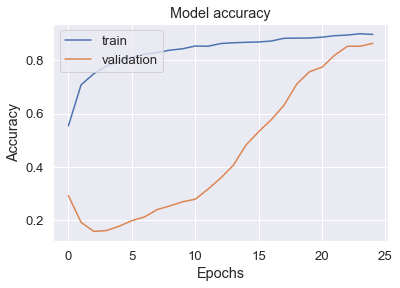

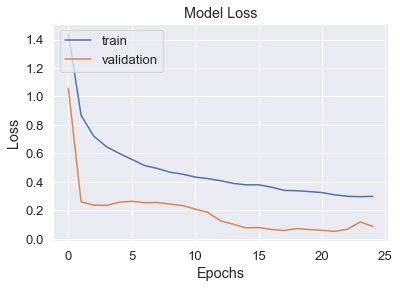

In [33]:
history_cnn_2_5  = model_cnn_2_5.fit_generator(train_generator,
                              steps_per_epoch =  math.ceil(train_generator.samples/ train_generator.batch_size),
                              epochs = 25,
                              validation_data = validation_generator,
                              validation_steps =  math.ceil(validation_generator.samples/validation_generator.batch_size),
                              verbose = 2)
visualize_acc_loss(history_cnn_2_5)

In [36]:
#could be trained further, but this is just to demonstrate the effect of removing extreme data augmentation
scores = model_cnn_2_5.evaluate_generator(test_generator,4050) #4050 test images 

In [41]:
print("Validation Accuracy = 86.42%")
print("Test Accuracy = {}%".format(round(scores[1]*100,2)))

Validation Accuracy = 86.42%
Test Accuracy = 86.86%


__Without__ 'extreme' data augmentation performed on the generator, the validation and test accuracy are much closer to each other . Of course if those 'extreme' augmentation were performed on only training data, it would be beneficial to the model as it can introduce variation to the existing training data which in turn prevent the model from overfitting on those same set of data. The limitation of using validation_split of ImageDataGenerator to get validation data is that augmentation performed on training data on the same generator will affect the validation set as well, hence in this case, only minimal augmentation were applied (vertical and horizontal flip)

# Final part: Focus on getting the model with the best performance
- Will tryout different hyperparameters and architecture

In [44]:
#Addition of batch normalization after each max pool and dense layer
leaky_relu_alpha = 0.1

model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(64,64,3),padding='same',kernel_initializer= 'he_uniform'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer = 'he_uniform'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(class_num))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_126 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_127 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 32, 32, 64)      

Epoch 1/100
 - 10s - loss: 1.7278 - accuracy: 0.4690 - val_loss: 0.8950 - val_accuracy: 0.2301
Epoch 2/100
 - 8s - loss: 1.1593 - accuracy: 0.6277 - val_loss: 0.7998 - val_accuracy: 0.1842
Epoch 3/100
 - 9s - loss: 0.9871 - accuracy: 0.6777 - val_loss: 0.5691 - val_accuracy: 0.1990
Epoch 4/100
 - 10s - loss: 0.8944 - accuracy: 0.7028 - val_loss: 0.5712 - val_accuracy: 0.1751
Epoch 5/100
 - 9s - loss: 0.8158 - accuracy: 0.7269 - val_loss: 0.5601 - val_accuracy: 0.1617
Epoch 6/100
 - 10s - loss: 0.7529 - accuracy: 0.7512 - val_loss: 0.4285 - val_accuracy: 0.1556
Epoch 7/100
 - 12s - loss: 0.7133 - accuracy: 0.7657 - val_loss: 0.4599 - val_accuracy: 0.1580
Epoch 8/100
 - 9s - loss: 0.6669 - accuracy: 0.7793 - val_loss: 0.4864 - val_accuracy: 0.1657
Epoch 9/100
 - 9s - loss: 0.6432 - accuracy: 0.7847 - val_loss: 0.4613 - val_accuracy: 0.1780
Epoch 10/100
 - 8s - loss: 0.6103 - accuracy: 0.7976 - val_loss: 0.4530 - val_accuracy: 0.1958
Epoch 11/100
 - 8s - loss: 0.5702 - accuracy: 0.8105 - 

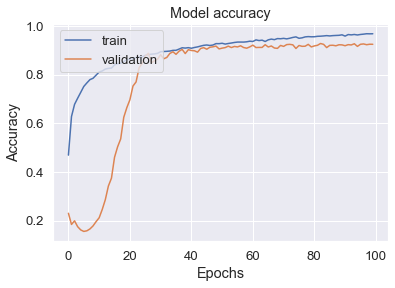

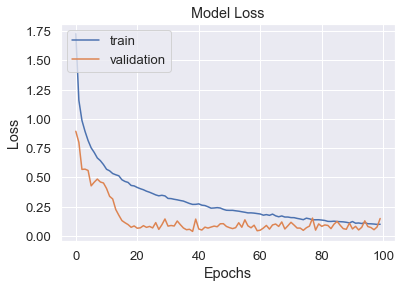

In [45]:
history  = model.fit_generator(train_generator,
                              steps_per_epoch =  math.ceil(train_generator.samples/ train_generator.batch_size),
                              epochs = 100,
                              validation_data = validation_generator,
                              validation_steps =  math.ceil(validation_generator.samples/validation_generator.batch_size),
                              verbose = 2)
visualize_acc_loss(history)

Confusion Matrix for Validation Data


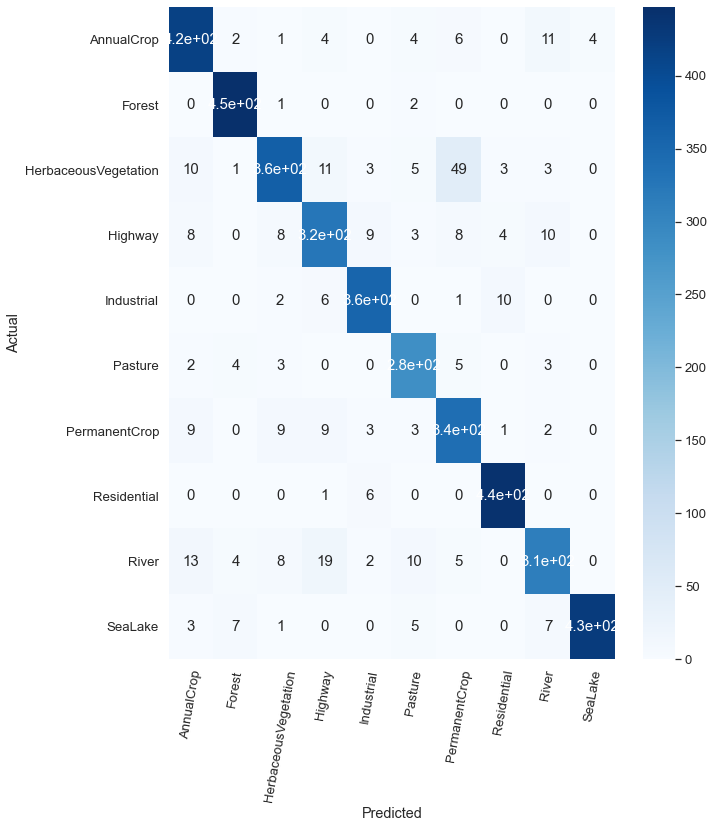

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.90      0.93      0.92       450
              Forest       0.96      0.99      0.98       450
HerbaceousVegetation       0.92      0.81      0.86       450
             Highway       0.87      0.87      0.87       375
          Industrial       0.94      0.95      0.94       375
             Pasture       0.90      0.94      0.92       300
       PermanentCrop       0.82      0.90      0.86       375
         Residential       0.96      0.98      0.97       450
               River       0.90      0.84      0.87       375
             SeaLake       0.99      0.95      0.97       450

            accuracy                           0.92      4050
           macro avg       0.92      0.92      0.92      4050
        weighted avg       0.92      0.92      0.92      4050



In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

class_list = list(train_generator.class_indices.keys())
Y_pred = model.predict_generator(validation_generator, 4050 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix for Validation Data')
conf_mat = confusion_matrix(validation_generator.classes, y_pred)

df_cm = pd.DataFrame(conf_mat, columns=class_list, index = class_list)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,12))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 15})

plt.xticks(rotation=80)
plt.show()


print('Classification Report')
target_names = class_list
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


In [47]:
scores = model.evaluate_generator(test_generator,4050) #4050 test images 

In [48]:
print("Validation Accuracy = 92.24%")
print("Test Accuracy = {}%".format(round(scores[1]*100,2)))

Validation Accuracy = 92.24%
Test Accuracy = 92.67%


In [49]:
import pickle
filename = "sentinel2_final_model.sav"
pickle.dump(model, open(filename, 'wb'))

Confusion Matrix for Test Data


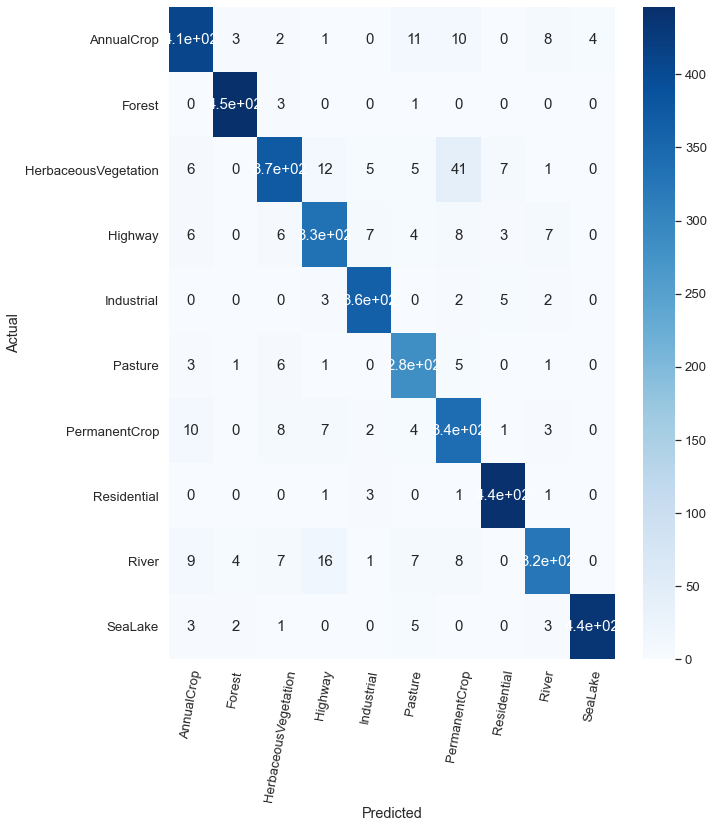

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.91      0.92       450
              Forest       0.98      0.99      0.98       450
HerbaceousVegetation       0.92      0.83      0.87       450
             Highway       0.89      0.89      0.89       375
          Industrial       0.95      0.97      0.96       375
             Pasture       0.88      0.94      0.91       300
       PermanentCrop       0.82      0.91      0.86       375
         Residential       0.97      0.99      0.98       450
               River       0.93      0.86      0.89       375
             SeaLake       0.99      0.97      0.98       450

            accuracy                           0.93      4050
           macro avg       0.92      0.93      0.92      4050
        weighted avg       0.93      0.93      0.93      4050



In [51]:
Y_pred = model.predict_generator(test_generator, 4050 // 64+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix for Test Data')
conf_mat = confusion_matrix(validation_generator.classes, y_pred)

df_cm = pd.DataFrame(conf_mat, columns=class_list, index = class_list)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,12))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 15})

plt.xticks(rotation=80)
plt.show()


print('Classification Report')
target_names = class_list
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

## Notes
The final model achieved 92.67% test accuracy. This model manage to perform better in certain classes as compared to the intial approach of transfer learning using Vgg16 model with imagenet weights. More data are required for these two classes in order to improve their results. Perhaps a deeper network + longer train would improve the model's performance much more.
This notebook is just for me to discover and try concepts and methods learnt from online courses. 
#### Remaining issue 
1. Why batch normalization cause an increase in validation loss then proceed to converge after several epochs. (Will revisit)
    - This abnormal pattern does not exist if shuffling for the validation data generator is switched off.